# <center> Solar Panels detection - Image classification </center>

In this notebook, we build a simple CNN classifier to detect solar panels in aerial images of the South of France.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-images-&amp;-labels" data-toc-modified-id="Loading-images-&amp;-labels-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading images &amp; labels</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Image-engineering" data-toc-modified-id="Image-engineering-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Image engineering</a></span></li><li><span><a href="#Class-imbalance" data-toc-modified-id="Class-imbalance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Class imbalance</a></span></li><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Train-test-split</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#PV-classification---no-data-augmentation" data-toc-modified-id="PV-classification---no-data-augmentation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>PV classification - no data augmentation</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li><li><span><a href="#PV-classification---&quot;on-the-fly&quot;-data-augmentation" data-toc-modified-id="PV-classification---&quot;on-the-fly&quot;-data-augmentation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>PV classification - "on the fly" data augmentation</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Other-evaluation-tools" data-toc-modified-id="Other-evaluation-tools-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Other evaluation tools</a></span></li></ul></li><li><span><a href="#Pre-trained-model" data-toc-modified-id="Pre-trained-model-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Pre-trained model</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Cross-validation</a></span><ul class="toc-item"><li><span><a href="#Stratified-K-Fold-Cross-Validation-with-Keras" data-toc-modified-id="Stratified-K-Fold-Cross-Validation-with-Keras-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Stratified K-Fold Cross Validation with Keras</a></span></li><li><span><a href="#Cross-validation-with-&quot;on-the-fly&quot;-augmented-data-generation-[not-implemented]" data-toc-modified-id="Cross-validation-with-&quot;on-the-fly&quot;-augmented-data-generation-[not-implemented]-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Cross-validation with "on-the-fly" augmented data generation [not implemented]</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [155]:
# regular ML imports
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import time
import random
import os
from os import listdir
import glob
import shutil

# image manipulation imports
import numpy as np
from PIL import Image
import cv2
from scipy import ndarray
import skimage as sk
from skimage import io 
from skimage import transform, img_as_ubyte
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage import util
from skimage.util import random_noise
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

# DL modeling imports
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy, binary_crossentropy

## Loading images & labels

Let's load all our images as a list of np arrays, using matplotlib (faster):

In [25]:
# Method 2 (final method): load images in alphabetical order, to match with labels' csv file

filenames = glob.glob('../Data/Data sud france classif/Images/img_sat_*.png')
filenames.sort()

loaded_images = [matplotlib.image.imread(img) for img in filenames] # list comprehension rather than loop
loaded_images = np.asarray(loaded_images)

print('Dataset shape:', loaded_images.shape)

Dataset shape: (193,)


And let's load our labels:

In [3]:
labels = pd.read_csv('../Data/Data sud france classif/Labels/annotation_boolean.csv', ';')
labels.head()

,image,has_pv,has_pool
0,img_sat_1.png,1,0
1,img_sat_10.png,0,1
2,img_sat_100.png,1,1
3,img_sat_101.png,0,1
4,img_sat_102.png,0,1


In [55]:
# count nb of positive and negative samples
print(labels.drop(columns=['image']).sum())
print(labels.drop(columns=['image']).sum()/len(labels))

has_pv      30
has_pool    86
dtype: int64
has_pv      0.155440
has_pool    0.445596
dtype: float64


Our dataset only has 30 positive PV samples, which represents only 15.5% of the dataset. For pools it's a little higher, but there is still **strong class imbalance**. To train a performant model, we will have to correct this by increasing the proportion of positive samples in the training data.

We split and reshape label to prepare them for CNN training:

In [4]:
# split pool and PV labels
has_pv = np.asarray(labels.has_pv)
has_pool = np.asarray(labels.has_pool)

# reshape pool and PV labels for training
has_pv = has_pv.reshape((193,1))
has_pool = has_pool.reshape((193,1))
print(has_pv.shape)
print(has_pool.shape)

(193, 1)
(193, 1)


In [5]:
# store all label values
label_values = labels.drop(columns=['image']).values
label_values.shape

(193, 2)

## Preprocessing

### Image engineering

* Normalize our images

In [26]:
# check that images in our dataset are already normalized
print('Data Type: %s' % loaded_images[0].dtype)
print('Min: %.3f, Max: %.3f' % (loaded_images[0].min(), loaded_images[0].max()))

Data Type: float32
Min: 0.000, Max: 1.000


Which means our dataset `loaded_images` is already normalized - good!

* Center and standardize

Centering and standardizing pixels values could also be useful as an additional step. See blog post:
https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/

* Resize

In [27]:
# resize all images to 400x400 pixels (smallest size in the dataset)
dataset = [resize(image, (400, 400)) for image in loaded_images]
print(dataset[0].shape)

(400, 400, 3)


In [28]:
dataset = np.asarray(dataset)
print(type(dataset))
print(dataset.shape)

<class 'numpy.ndarray'>
(193, 400, 400, 3)


### Class imbalance

To reduce class imbalance, let's remove from the initial dataset the images for which there is neither pool nor PV panels.

In [124]:
# sum pool and PV labels
labels_imbalanced = labels.drop(columns=['image'])
print(sum(labels_imbalanced.values))
sum_labels = labels_imbalanced.sum(axis=1)
print(sum_labels)

[30 86]
0      1
1      1
2      2
3      1
4      1
      ..
188    0
189    1
190    1
191    1
192    2
Length: 193, dtype: int64


In [125]:
# obtain indices where sum = 0
indices_nonzero = sum_labels.values.nonzero()[0]
indices_zero = np.nonzero(sum_labels.values == 0)[0]
print(len(indices_nonzero))
print(len(indices_zero))

98
95


In [165]:
# delete the corresponding indices from training labels
labels_balanced = np.delete(label_values, indices_zero, 0)
has_pv_balanced = np.delete(has_pv, indices_zero, 0)
has_pool_balanced = np.delete(has_pool, indices_zero, 0)

print(len(labels_balanced))
print(sum(labels_balanced))

98
[30 86]


In [133]:
# delete the corresponding indices from training images
dataset_balanced = np.delete(dataset, indices_zero, 0)
print(len(dataset_balanced))

98


`labels_balanced` now only contains 98 samples, corresponding to those with at least one of PV panels or pool. 30 of them have PV panels, which corresponds to approximately **30%** and **doubles the proportion of positive PV samples** (vs. 15% before).

### Train-test-split

The cell below creates training and testing sets, for PV classification:

In [136]:
x_train, x_test, y_train, y_test = train_test_split(dataset_balanced, has_pv_balanced, 
                                                    test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(78, 400, 400, 3) (78, 1)
(20, 400, 400, 3) (20, 1)


We also store the full dataset (without split) as `X_train` and `Y_train` (capital letters):

In [184]:
X_train = dataset_balanced
Y_train = has_pv_balanced
print(X_train.shape, Y_train.shape)

(98, 400, 400, 3) (98, 1)


Same for classification of PV panels and pool presence together:

In [185]:
x_train_both, x_test_both, y_train_both, y_test_both = train_test_split(dataset_balanced, labels_balanced, 
                                                                        test_size=0.2, random_state=42)
Y_train_both = labels_balanced

## Model

### PV classification - no data augmentation

Let's start with a model for PV classification only, and using only the original dataset (no data augmentation). As I don't have a lot of computing power on my personal laptop it's a very small model (only 2 conv layers with relu activation and 3x3 kernel, both followed by max pooling, and 1 dense layer followed by the output layer - no batch normalization or dropout, and rather small layer sizes overall).

#### Training

In [22]:
# Hyperparameters:
input_shape = X_train.shape[1:]
batch_size = 16
epochs = 4
validation_split = 0.2

In [23]:
model = Sequential()
    
model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=binary_crossentropy,
                  optimizer=SGD(), # parameters (lr, momentum) could also be tuned
                  metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 398, 398, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 199, 199, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 197, 197, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 614656)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               78676096  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [31]:
cnn_pv_noaug = model.fit(X_train, Y_train, batch_size=batch_size, 
                         epochs=epochs, verbose=1, validation_split=validation_split)

# remark: for validation we can either use the result of `train_test_split`,
# with the argument `validation_data = (x_test, y_test)`,
# or use the `validation_split` argument, with a chosen split proportion

Train on 154 samples, validate on 39 samples
Epoch 1/4
154/154 [==============================] - 56s 363ms/step - loss: 0.5122 - accuracy: 0.8442 - val_loss: 0.4734 - val_accuracy: 0.8462
Epoch 2/4
154/154 [==============================] - 39s 255ms/step - loss: 0.4677 - accuracy: 0.8442 - val_loss: 0.4712 - val_accuracy: 0.8462
Epoch 3/4
154/154 [==============================] - 40s 258ms/step - loss: 0.4499 - accuracy: 0.8442 - val_loss: 0.5651 - val_accuracy: 0.8462
Epoch 4/4
154/154 [==============================] - 37s 240ms/step - loss: 0.4162 - accuracy: 0.8442 - val_loss: 0.4675 - val_accuracy: 0.8462


#### Evaluation

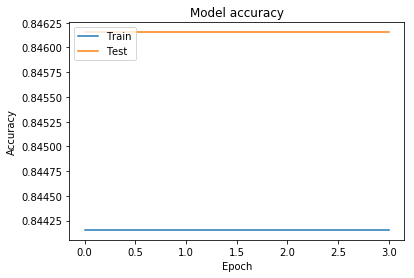

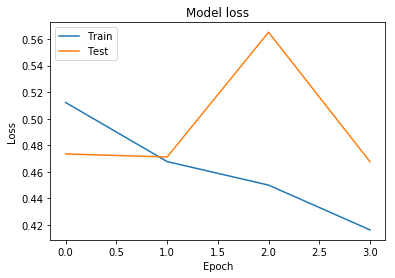

In [32]:
# plot the training and validation loss and accuracy per epoch (separated plots)

history = cnn_pv_noaug

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

We did not train on a sufficient number of samples to see differences in accuracy from one epoch to the other, but thes graphs could be very useful for evaluating a model trained on an augmented dataset (with approach 1, not computed here due to computing power limitations).

In [49]:
# print the classification report (from sklearn)
predictions = model.predict(x_test, batch_size=batch_size)
print(classification_report(y_test, predictions.argmax(axis=1), target_names=['PV presence']))

             precision    recall  f1-score   support

PV presence       0.92      1.00      0.96        36

avg / total       0.85      0.92      0.89        39



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 1
  .format(len(labels), len(target_names))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We can see that our scores are high, but this is due to **class imbalance**: as we have much more negative samples (no PV panels) than positive samples, even a model always predicting "no PV panel" would get a very high score.

To improve this model, we need:
* more images $\rightarrow$ data augmentation, see last section in this notebook
* more positive samples $\rightarrow$ correct class imbalance
* a more complex model $\rightarrow$ possible when we have more data
* more performant hyperparameters $\rightarrow$ smaller batch size, etc.

### PV classification - "on the fly" data augmentation

With this "in-place" data augmentation approach, new images samples are generated at each epoch, i.e. the model trains on a new set of images (of size equal to original set) at each epoch.

#### Training

In [146]:
# Hyperparameters:
input_shape = X_train.shape[1:]
batch_size = 4
epochs = 12
validation_split = 0.2

In [147]:
model = Sequential()
    
model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=binary_crossentropy,
                  optimizer=SGD(),
                  metrics=['acc'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 398, 398, 32)      896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 396, 396, 32)      9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 198, 198, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 196, 196, 64)      18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 194, 194, 64)      36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 97, 97, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 602176)           

In [157]:
# initialize data generator (default parameters)
datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.15, width_shift_range=0.2, 
                             height_shift_range=0.2, shear_range=0.15, 
                             horizontal_flip=True, fill_mode="reflect")

In [149]:
# train the network
cnn_pv_aug = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                 validation_data=(x_test,y_test), epochs=epochs, verbose=1)
# remark: with fit_generator, we have to use the split from `train_test_split`

Epoch 1/12
20/20 [==============================] - 55s 3s/step - loss: 0.7346 - acc: 0.6154 - val_loss: 0.5943 - val_acc: 0.8000
Epoch 2/12
20/20 [==============================] - 51s 3s/step - loss: 0.6633 - acc: 0.6667 - val_loss: 0.5615 - val_acc: 0.8000
Epoch 3/12
20/20 [==============================] - 51s 3s/step - loss: 0.6735 - acc: 0.6667 - val_loss: 0.6184 - val_acc: 0.8000
Epoch 4/12
20/20 [==============================] - 49s 2s/step - loss: 0.6567 - acc: 0.6667 - val_loss: 0.6406 - val_acc: 0.8000
Epoch 5/12
20/20 [==============================] - 48s 2s/step - loss: 0.6620 - acc: 0.6667 - val_loss: 0.5793 - val_acc: 0.8000
Epoch 6/12
20/20 [==============================] - 48s 2s/step - loss: 0.6562 - acc: 0.6667 - val_loss: 0.5957 - val_acc: 0.8000
Epoch 7/12
20/20 [==============================] - 53s 3s/step - loss: 0.6589 - acc: 0.6667 - val_loss: 0.5645 - val_acc: 0.8000
Epoch 8/12
20/20 [==============================] - 54s 3s/step - loss: 0.6504 - acc: 0.66

#### Evaluation

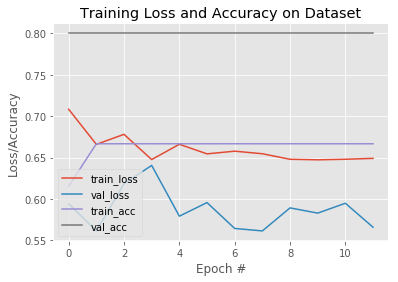

In [150]:
# plot the training and validation loss and accuracy per epoch (unique plot)
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, cnn_pv_aug.history["loss"], label="train_loss")
plt.plot(N, cnn_pv_aug.history["val_loss"], label="val_loss")
plt.plot(N, cnn_pv_aug.history["acc"], label="train_acc")
plt.plot(N, cnn_pv_aug.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [151]:
# print the classification report (from sklearn)
predictions = model.predict(x_test, batch_size=batch_size)
print(classification_report(y_test, predictions.argmax(axis=1), target_names=['PV presence']))

             precision    recall  f1-score   support

PV presence       0.80      1.00      0.89        16

avg / total       0.64      0.80      0.71        20



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 1
  .format(len(labels), len(target_names))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We get rather close scores with and without data augmentation, due to the limited number of epochs and to a limited amount of data, even with data augmentation.

To improve this model, we need:
* more images $\rightarrow$ add new original data, and perform data augmentation again
* more positive samples $\rightarrow$ correct class imbalance by adding more orignal positive data
* a more complex model $\rightarrow$ possible when we have more data
* more performant hyperparameters $\rightarrow$ smaller batch size, etc.
* cross-validation $\rightarrow$ possible with more computational power.

#### Other evaluation tools

Due to short training and limited data, these tools aren't relevant yet, but once we have more images to train on, they should be tuned and re-run to get useful insights.

* Image class probabilities:

In [189]:
def predict_probas(y_prob, x, labels, file_name=None):
    
    fig = plt.figure(figsize=(20, 20))
    index=1
    for i in range(0,3):
        fig.add_subplot(8, 2, index)
        plt.imshow(x_test[i])
        index+=1
        
        fig.add_subplot(8, 2, index)
        plt.barh(y = labels,width=y_prob[i] )
        index+=1
        
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

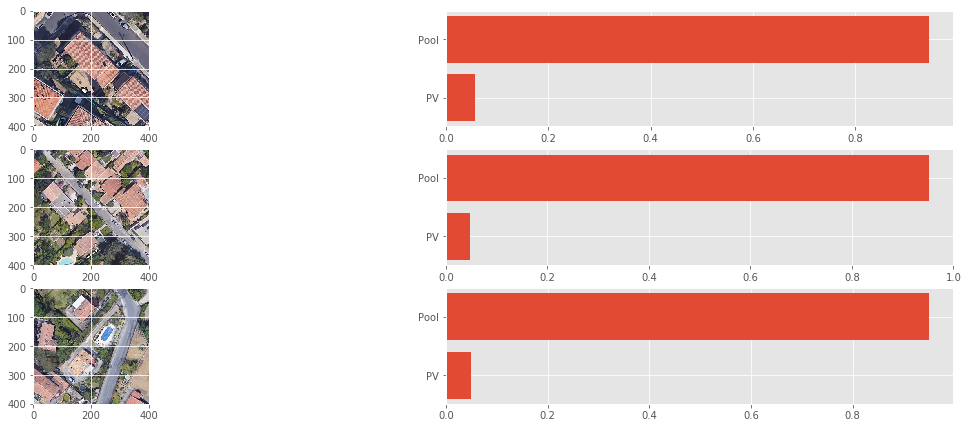

In [187]:
y_prob = model.predict(x_test_both)
labels = ['PV','Pool']

predict_probas(y_prob, x_test_both, labels)

* Confusion matrix:

In [182]:
def get_class_true(y):
    y_labeled = []
    for ind in y:
        i = np.where(ind == 1)
        y_labeled.append(labels[i[0][0]])
    return y_labeled

def get_class_pred(y):
    y_labeled = []
    for ind in y:
        y_labeled.append(labels[ind])
    return y_labeled

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    pred_true = pd.DataFrame({'y_test': get_class_true(y_true), 'y_pred': get_class_pred(y_pred)})
    print(pred_true)
    confusion = confusion_matrix(pred_true.y_test, pred_true.y_pred).ravel()
    confusion = pd.crosstab(pred_true['y_test'], pred_true['y_pred'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion)

   y_test y_pred
0      PV   Pool
1    Pool   Pool
2    Pool   Pool
3      PV   Pool
4    Pool   Pool
5    Pool   Pool
6    Pool   Pool
7      PV   Pool
8    Pool   Pool
9      PV   Pool
10   Pool   Pool
11   Pool   Pool
12   Pool   Pool
13   Pool   Pool
14   Pool   Pool
15   Pool   Pool
16   Pool   Pool
17   Pool   Pool
18   Pool   Pool
19   Pool   Pool


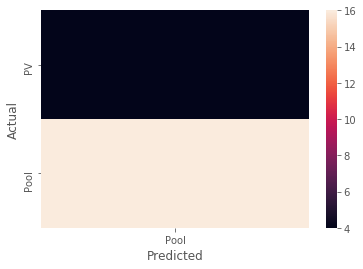

In [188]:
y_pred = model.predict_classes(x_test_both)
    
plot_confusion_matrix(y_test_both, y_pred, classes = labels)

### Pre-trained model

Finally, I tried to adapt a pre-trained network (VGG16, trained on the ImageNet dataset) to our problem.

In [ ]:
# Import pre-trained model

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=x_train.shape[1:])

In [ ]:
conv_base.summary()

#### Training

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. We will run our data through this conv_base network and then add a densely-connected classifier on top (2 dense layers), which we will train from scratch on our data so that the new model finally becomes adapted to our problem.

In [ ]:
features = conv_base.predict(x_test)

In [ ]:
# define the full model

model_pretrained = Sequential()

model_pretrained.add(conv_base) # add the pre-trained conv_base
model_pretrained.add(Flatten()) # flatten output and add 2 final dense layers
model_pretrained.add(Dense(512, activation='relu'))
model_pretrained.add(Dense(output_dim = 10, activation='softmax'))

model_pretrained.summary()

In [ ]:
# freeze the pre-trained conv layers for training

print('This is the number of trainable weights '
      'before freezing the conv base:', len(model_pretrained.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model_pretrained.trainable_weights))

In [ ]:
# train the model on our data

model_pretrained.compile(loss=categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['accuracy'])

history = model_pretrained.fit(x_train, y_train, batch_size=32,
      epochs=10,
      validation_split=0.25,
      verbose=1)

#### Evaluation

In [ ]:
# plot performance

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Fine-tuning**  

To push performance even further, we could also fine-tune the last top layers of the conv_base. We did not do it here because of training time, but here is how and why we could have done it:  
* Fine-tuning would consist in unfreezing a few of the top layers of the convolutional model base, so we can slightly re-adjust the more abstract representations and make them more relevant for our problem.
* We could fine-tune the entire convolutional base, but we'd rather just unfreeze the top layers - the reason is that the earlier layers encode more generic, reusable features, while layers higher up (the 2-3 top layers) encode more specialized features, which can be repurposed on our new problem.
* To train these layers we should use a very low learning rate, in order to limit the magnitude of the modifications we make (updates that are too large may harm the previous representations).
* Using a pre-trained model and fine-tuning it to our specific problem allows to reach stronger performance on a small dataset.

### Cross-validation

Regular cross-validation in `sklearn` works as presented in the following short example:

> `# Perform 6-fold cross validation
scores = cross_val_score(model, x_train, y_train, cv=2)
print("Cross-validated scores:", scores)`

Unfortunately, this doesn't work with a `keras` model. Below, we present several other cross-validation methods relevant to image analysis with Keras, but not impremented yet - as we don't have enough data for now to use cross-validation in a significant way.

#### Stratified K-Fold Cross Validation with Keras

K-fold cross validation provides a robust estimate of the performance of a model on unseen data. It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset. The process is repeated until all subsets are given an opportunity to be the held out as validation set. The performance measure is then averaged across all models that were created.

The `StratifiedKFold` class from `scikit-learn` creates stratified folds, meaning that the algorithm attempts to balance the number of instances of each class in each fold.

Cross validation implies lots of computational expenses, as 5 or 10 folds imply that 5 or 10 models must be constructed and evaluated. However with enough power it provides a less biased estimate of the performance of your model (average and standard deviation of model performance, outputted at the end of the following script).

In [ ]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# train and evaluate 10 models
cvscores = []
for train, test in kfold.split(x_train, y_train):
  # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    .
    .
    .
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(x_train, y_train, epochs=5, batch_size=8, verbose=0)
    # evaluate the model
    scores = model.evaluate(x_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

To run this cell, we would need more computational power than my personal laptop.

#### Cross-validation with "on-the-fly" augmented data generation [not implemented]

If you are using images with data generators, here's one way to do 10-fold cross-validation with Keras and scikit-learn. The strategy is to copy the files to training, validation, and test subfolders according to each fold.

In [ ]:
# used to copy files according to each fold
def copy_images(df, directory):
    destination_directory = "{path to your data directory}/" + directory
    print("copying {} files to {}...".format(directory, destination_directory))

    # remove all files from previous fold
    if os.path.exists(destination_directory):
        shutil.rmtree(destination_directory)

    # create folder for files from this fold
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    # create subfolders for each class
    for c in set(list(df['class'])):
        if not os.path.exists(destination_directory + '/' + c):
            os.makedirs(destination_directory + '/' + c)

    # copy files for this fold from a directory holding all the files
    for i, row in df.iterrows():
        try:
            # this is the path to all of your images kept together in a separate folder
            path_from = "{path to all of your images}"
            path_from = path_from + "{}.jpg"
            path_to = "{}/{}".format(destination_directory, row['class'])

            # move from folder keeping all files to training, test, or validation folder (the "directory" argument)
            shutil.copy(path_from.format(row['filename']), path_to)
        except Exception, e:
            print("Error when copying {}: {}".format(row['filename'], str(e)))

# dataframe containing the filenames of the images (e.g., GUID filenames) and the classes
df = pd.read_csv('{path to your data}.csv')
df_y = df['class']
df_x = df
del df_x['class']

skf = StratifiedKFold(n_splits = 10)
total_actual = []
total_predicted = []
total_val_accuracy = []
total_val_loss = []
total_test_accuracy = []

for i, (train_index, test_index) in enumerate(skf.split(df_x, df_y)):
    x_train, x_test = df_x.iloc[train_index], df_x.iloc[test_index]
    y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]

    train = pd.concat([x_train, y_train], axis=1)
    test = pd.concat([x_test, y_test], axis = 1)

    # take 20% of the training data from this fold for validation during training
    validation = train.sample(frac = 0.2)

    # make sure validation data does not include training data
    train = train[~train['filename'].isin(list(validation['filename']))]

    # copy the images according to the fold
    copy_images(train, 'training')
    copy_images(validation, 'validation')
    copy_images(test, 'test')

    print('**** Running fold '+ str(i))

    # here you call a function to create and train your model, returning validation accuracy and validation loss
    val_accuracy, val_loss = create_train_model();

    # append validation accuracy and loss for average calculation later on
    total_val_accuracy.append(val_accuracy)
    total_val_loss.append(val_loss)

    # here you will call a predict() method that will predict the images on the "test" subfolder 
    # this function returns the actual classes and the predicted classes in the same order
    actual, predicted = predict()

    # append accuracy from the predictions on the test data
    total_test_accuracy.append(accuracy_score(actual, predicted))

    # append all of the actual and predicted classes for your final evaluation
    total_actual = total_actual + actual
    total_predicted = total_predicted + predicted

    # this is optional, but you can also see the performance on each fold as the process goes on
    print(classification_report(total_actual, total_predicted))
    print(confusion_matrix(total_actual, total_predicted))

print(classification_report(total_actual, total_predicted))
print(confusion_matrix(total_actual, total_predicted))
print("Validation accuracy on each fold:")
print(total_val_accuracy)
print("Mean validation accuracy: {}%".format(np.mean(total_val_accuracy) * 100))

print("Validation loss on each fold:")
print(total_val_loss)
print("Mean validation loss: {}".format(np.mean(total_val_loss)))

print("Test accuracy on each fold:")
print(total_test_accuracy)
print("Mean test accuracy: {}%".format(np.mean(total_test_accuracy) * 100))

In your predict() function, if you are using a data generator, the only way I could find to keep the predictions in the same order when testing would be to use a batch_size of 1:

In [ ]:
generator = ImageDataGenerator().flow_from_directory(
        '{path to your data directory}/test',
        target_size = (img_width, img_height),
        batch_size = 1,
        color_mode = 'rgb',
        # categorical for a multiclass problem
        class_mode = 'categorical',
        # this will also ensure the same order
        shuffle = False)

With this code, I was able to do 10-fold cross-validation using data generators (so I did not have to keep all files in memory). This can be a lot of work if you have millions of images and the batch_size = 1 could be a bottleneck if your test set is large, but for my project this worked well.

## Conclusion

In this notebook, we finally come out with a minimum viable model to detect solar panels.

Due to limited data and computational power, we don't get very performant results, but everything works (pre-processing, modeling, evaluation) and could be used as a basis for further work.

Further work could include:
* more images $\rightarrow$ I will try to find more data, and perform data augmentation again
* more positive samples $\rightarrow$ I will especially add more positive date to correct class imbalance
* a more complex model, with tuned parameters $\rightarrow$ I will deepen and tune the models when I get more data and more computational power
* a pre-trained network $\rightarrow$ I will try to transfer learning from a pretrained network
* cross-validation $\rightarrow$ in order to have more computational power, I will try to run this notebook on GPU.